## Problem 1: Load the dataset

We will develop a convolution neural network for classifying images of berry, bird, dog, and flower. Let's download the dataset.

Download data from here . This dateset will be used for Problem 2 and Problem 3.

In [1]:
import glob
import numpy as np

import cv2
import tensorflow as tf

from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

(1) Design your train, validation, and test dataset using each folder.

In [2]:
train_imgs = np.array([cv2.resize(cv2.imread(file), (224, 224))
                       for file in glob.glob('train/**/*.jpg', recursive=True)])
valid_imgs = np.array([cv2.resize(cv2.imread(file), (224, 224)) 
                       for file in glob.glob('validation/**/*.jpg', recursive=True)])
test_imgs = np.array([cv2.resize(cv2.imread(file), (224, 224)) 
                      for file in glob.glob('test/**/*.jpg', recursive=True)])

In [3]:
train_imgs.shape, valid_imgs.shape, test_imgs.shape

((2400, 224, 224, 3), (400, 224, 224, 3), (800, 224, 224, 3))

In [4]:
list_labels = ['Flower', 'Berry', 'Bird', 'Dog']
train_labels = np.repeat(range(len(list_labels)), 600)
valid_labels = np.repeat(range(len(list_labels)), 100)
test_labels = np.repeat(range(len(list_labels)), 200)

In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_labels = enc.fit_transform(train_labels.reshape(-1, 1)).toarray()
valid_labels = enc.fit_transform(valid_labels.reshape(-1, 1)).toarray()
test_labels = enc.fit_transform(test_labels.reshape(-1, 1)).toarray()

(2) Plot 10 random data.

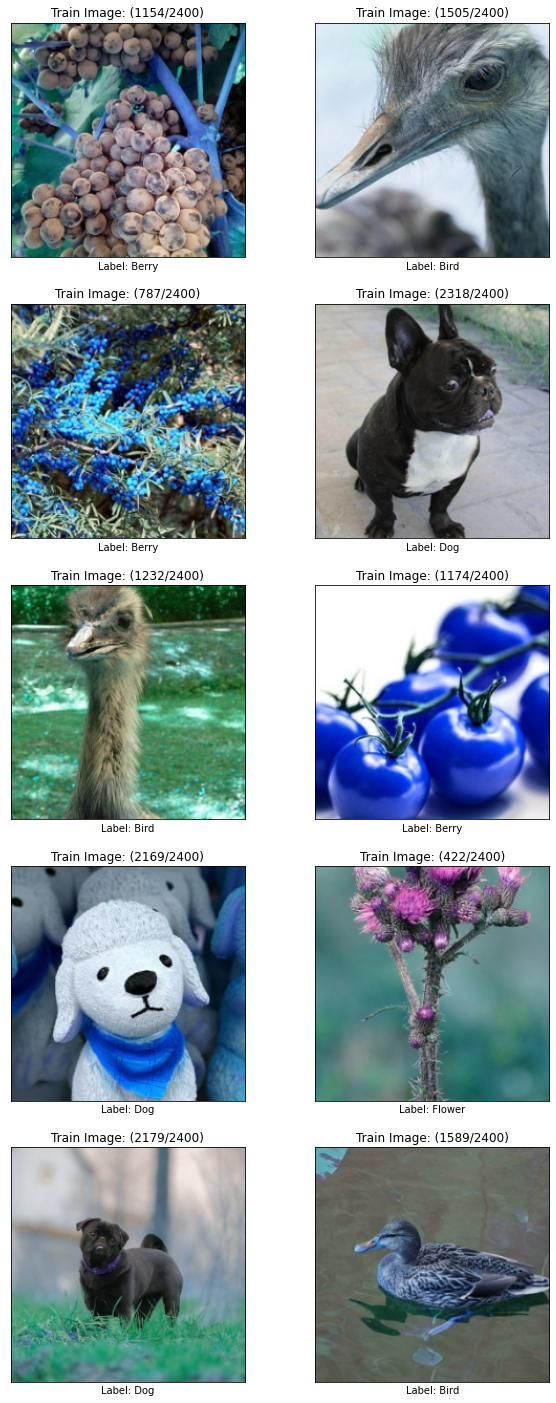

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(10, 25))
fig.set_facecolor('white')

for i, j in product(range(5), range(2)):
    rand_num = np.random.randint(len(train_imgs))
    axes[i, j].imshow(train_imgs[rand_num])
    axes[i, j].set_xlabel('Label: {}'.format(
        list_labels[np.argmax(train_labels[rand_num])]))
    axes[i, j].set_title('{}: ({}/{})'.format('Train Image', rand_num, len(train_imgs)))
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])

## Problem 2: Transfer Learning

We will use VGG16 architecture for training our dataset. As you can see below image, VGG16 architecture has 16 layer blcoks and a lot of training parameters. Because machine learning libraries, such as Tensorflow, Keras, and Pytorch, provide pre-trained models for ImageNet, we don't have to design and train the model from scratch.

<img src='./img_1.png' width="800" height="300">

(3) Design VGG16 model using machine learning libraries, such as Tensorflow, Keras, and Pytorch

In [7]:
model_type = tf.keras.applications.vgg16
vgg16_model = model_type.VGG16(weights='imagenet', 
                               include_top=False, 
                               input_shape=(224, 224, 3))
vgg16_model.trainable = False
vgg16_model.summary()

2021-11-18 01:43:18.998207: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 01:43:19.011785: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3100000000 Hz
2021-11-18 01:43:19.014485: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5596b038f130 executing computations on platform Host. Devices:
2021-11-18 01:43:19.014505: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2021-11-18 01:43:19.014577: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

(4) Modify original VGG16 architecture. As you can see below image, we will modify only fully connected layer part. Also, since we will use pre-trained parameters, parameters of the feature extraction part must be fixed.¶


<img src='./img_2.png' width="800" height="300">

In [17]:
model = tf.keras.models.Sequential([vgg16_model,
                                    tf.keras.layers.Conv2D(filters=1024, 
                                                           kernel_size=(3, 3), 
                                                           activation='relu',
                                                           padding='SAME'),
                                    tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(units=4, activation='softmax')])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 1024)        4719616   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 19,438,404
Trainable params: 4,723,716
Non-trainable params: 14,714,688
_________________________________________________________________


(5) Train the modified VGG16 model. You can get a perfect score if validation accuracy exceeds 90%.

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.fit(train_imgs, train_labels, batch_size=30, epochs=5, 
          validation_data=(valid_imgs, valid_labels))

Train on 2400 samples, validate on 400 samples
Epoch 1/5
2400/2400 [==============================] - 53s 22ms/sample - loss: 3.6655 - accuracy: 0.9033 - val_loss: 0.1369 - val_accuracy: 0.9850
Epoch 2/5
2400/2400 [==============================] - 57s 24ms/sample - loss: 0.0574 - accuracy: 0.9812 - val_loss: 0.1108 - val_accuracy: 0.9800
Epoch 3/5
2400/2400 [==============================] - 69s 29ms/sample - loss: 0.0308 - accuracy: 0.9921 - val_loss: 0.1007 - val_accuracy: 0.9925
Epoch 4/5
2400/2400 [==============================] - 76s 32ms/sample - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.1047 - val_accuracy: 0.9825
Epoch 5/5
2400/2400 [==============================] - 72s 30ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1109 - val_accuracy: 0.9825


(6) Print your accuracy about test dataset.

In [21]:
_, test_acc = model.evaluate(test_imgs, test_labels)

800/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
print('Test Accuracy: {:.4}'.format(test_acc))

Test Accuracy: 0.9875


## Problem 3: Class Activation Maps¶


(7) As shown in the given figure, plot the CAM results.

In [23]:
# get max pooling layer and fully connected layer 
conv_layer = model.get_layer(index=1)
fc_layer = model.layers[3].get_weights()[0]

# Class activation map 
my_map = tf.matmul(conv_layer.output, fc_layer)
CAM = tf.keras.Model(inputs=model.inputs, outputs=my_map)

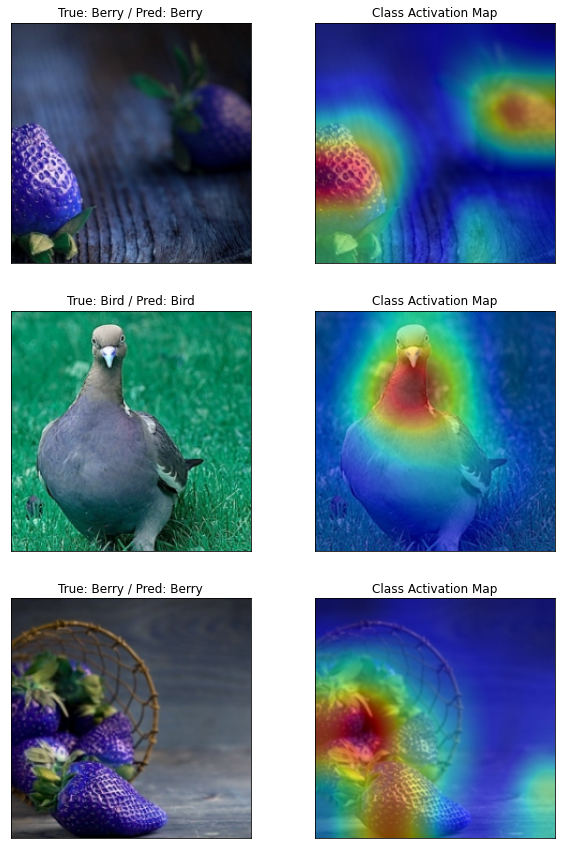

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.set_facecolor('white')

for i in range(3):
    rand_num = np.random.randint(len(test_imgs))
    cam_img = test_imgs[[rand_num]]
    for j in range(2):

        pred = np.argmax(model.predict(tf.cast(cam_img, tf.float32)))

        if j == 1:
            predCAM = CAM.predict(tf.cast(cam_img, tf.float32))

            attention = predCAM[:, :, :, pred]
            attention = np.abs(np.reshape(attention, (7, 7)))

            resized_attention = cv2.resize(attention,
                                           (200*5, 200*5), 
                                           interpolation=cv2.INTER_CUBIC)

            resized_test_x = cv2.resize(cam_img.reshape(224, 224, 3), 
                                        (200*5, 200*5),
                                        interpolation=cv2.INTER_CUBIC)

            title = 'Class Activation Map'
            axes[i, j].imshow(resized_test_x)
            axes[i, j].imshow(resized_attention, 'jet', alpha=0.5)

        else:
            title = 'True: {} / Pred: {}'.format(
                list_labels[np.argmax(test_labels[rand_num])], list_labels[pred])

            axes[i, j].imshow(cam_img.reshape(224, 224, 3))

        axes[i, j].set_title(title)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])